# Kinetic surface model

This task will show how to include the kinetics surface model in FESTIM simulations. 

We will study a 1D transient case with one trap, uniformly distributed over the domain.

The traps are assumed to be pre-filled with hydrogen up to 0.1 at.%, whereas the solute hydrogen is assumed to be absent. Then, the left sample's surface will be exposed to an impulse heat load with nanosecond duration. Moreover, we will assume that the sample is exposed to a low-energy hydrogen flux of $10^{19}~\mathrm{atoms/m}^{2}$.

**Note:** Current implementation of the kinetic surface model supports only 1D simulations.

## FESTIM model

To start with, we will define a mesh, a material, and traps. For material, we will use the properties of tungsten. 

In [1]:
import festim as F
import h_transport_materials as htm
import numpy as np
import sympy as sp

# Bulk parameters
n_W = 6.31e28  # W atomic density, m^-3
lambda_W = n_W ** (-1 / 3)  # characteristic dist

# Thermal properties
rho_W = 19250  # W mass density, kg/m^3
kappa_W = 170  # W thermal conductivity, W/m/K
Cp_W = 130  # W specific heat capacity, J/kg/K

D = (
    htm.diffusivities.filter(material="tungsten")
    .filter(isotope="h")
    .filter(author="fernandez")[0]
)

my_model = F.Simulation()

# Mesh
vertices = np.concatenate(
    [np.linspace(0, 1e-6, num=1000), np.linspace(1e-6, 100e-6, num=500)]
)

my_model.mesh = F.MeshFromVertices(vertices)

# Materials
my_model.materials = F.Material(
    id=1,
    D_0=D.pre_exp.magnitude,
    E_D=D.act_energy.magnitude,
    rho=rho_W,
    thermal_cond=kappa_W,
    heat_capacity=Cp_W,
)

# Traps
my_model.traps = F.Trap(
    k_0=D.pre_exp.magnitude / (n_W * 6.6e-12**2),
    E_k=D.act_energy.magnitude,
    p_0=1e13,
    E_p=1.25,
    density=1e-2 * n_W,
    materials=my_model.materials[0],
)

# Initial conditions
my_model.initial_conditions = [F.InitialCondition(field="1", value=1e-2 * n_W)]

For this task, we will consider a transient heat transfer problem with initial temperature equal to 300 K. Material temperature will be governed by an impulse heat load on the left surface and fixed temperature (300 K) on the right. To set an impulse load, we choose a shifted Gauss distribution.

In [2]:
def heat_pulse(t):
    # Heat flux impulse
    sigma = 30e-9
    t0 = 100e-9
    return 10e3 / np.sqrt(2 * np.pi) / sigma * sp.exp(-((t - t0) ** 2) / 2 / sigma**2)


# Heat transfer
my_model.T = F.HeatTransferProblem(
    absolute_tolerance=1e-5,
    relative_tolerance=1e-7,
    initial_condition=300,
)

In FESTIM, the kinetic surface model can be included by applying the `SurfaceKinetics` boundary conditions for solute hydrogen. This model introduces new species called "adsorbed hydrogen" and dynamically updates their surface concentration ($c_{\mathrm{s}}$ in $\mathrm{m}^{-2}$) based on the flux balance of atoms coming/leaving the surface. Please, see the corresponding [theory section](https://festim.readthedocs.io/en/latest/theory.html#kinetic-surface-model) for details.

To set this boundary condition, we need to specify the rate constant $k_{\mathrm{sb}}$ for the surface-to-subsurface transition (in ${\mathrm{s}}^{-1}$), the rate constant $k_{\mathrm{bs}}$ for the subsurface-to-surface transition (in ${\mathrm{s}}^{-1}$), characteristic distance between two iterstitial sites $\lambda_{\mathrm{IS}}$ (in m), surface concentration of adsorption sites $n_{\mathrm{surf}}$ (in $\mathrm{m}^{-2}$), bulk concentration of interstitial sites $n_{\mathrm{IS}}$ (in $\mathrm{m}^{-3}$), the net flux from the vacuum to the surface $J_{\mathrm{vs}}$ (in $\mathrm{m}^{-2}\mathrm{s}^{-1}$). Rate constants and the flux $J_{\mathrm{vs}}$ can take a float or a function of adsorbed hydrogen concentration, temperature, and other parameters such as time.

In this task, we will consider hydrogen adsorption on the left surface with flux $J_{\mathrm{ads}}$ due to atomic exposure and hydrogen desorption due to recombination $J_{\mathrm{des}}$. On the right surface, we will set the hydrogen concentration to zero.

In [3]:
import fenics as f

n_IS = 6 * n_W  # Atomic density of interstitial sites, m^-3
lambda_W = 110e-12  # Characteristic distance between two interstitial sites, m
n_surf = n_W ** (2 / 3)  # Concentration of adsorption sites, m^-2


def J_vs(T, surf_conc):
    # Net flux from the vacuum onto the surface

    J_ads = 1e23 * (1 - surf_conc / n_surf)  # adsorption flux

    J_des = 2 * 1e13 * surf_conc**2 / n_surf * f.exp(-1.2 / F.k_B / T)

    return J_ads - J_des


def k_bs(T, surf_conc):
    return 1e13 * f.exp(-0.2 / F.k_B / T)


def k_sb(T, surf_conc):
    return 1e13 * f.exp(-1.5 / F.k_B / T)


my_model.boundary_conditions = [
    F.FluxBC(field="T", surfaces=1, value=heat_pulse(F.t)),
    F.DirichletBC(field="T", surfaces=2, value=300),
    F.SurfaceKinetics(
        k_bs=k_bs,
        k_sb=k_sb,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        lambda_IS=lambda_W,
        surfaces=1,
        initial_condition=0,
    ),
    F.DirichletBC(surfaces=2, field=0, value=0),
]

Now, we can set exports and run the simulation. To export the hydrogen surface concentration $c_\mathrm{s}$, we will use a dedicated derived quantity class `AdsorbedHydrogen`.

In [4]:
derived_quantities = F.DerivedQuantities(
    [
        F.AdsorbedHydrogen(surface=1),
        F.TotalSurface(field="T", surface=1),
        F.ThermalFlux(surface=1),
        F.PointValue(field=0, x=0),
    ],
    show_units=True,
)

my_model.exports = [derived_quantities]

my_model.settings = F.Settings(
    absolute_tolerance=1e14,
    relative_tolerance=1e-10,
    final_time=5e-7,
)

my_model.dt = F.Stepsize(
    initial_value=1e-10,
    stepsize_change_ratio=1.1,
    max_stepsize=lambda t: 5e-10 if t < 1e-7 else 1e-7,
    dt_min=1e-12,
)

my_model.initialise()
my_model.run()

Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:385: UserWarning: <class 'festim.exports.derived_quantities.adsorbed_hydrogen.AdsorbedHydrogen'> may not work as intended for cartesian meshes
  warnings.warn(
/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:385: UserWarning: <class 'festim.exports.derived_quantities.total_surface.TotalSurface'> may not work as intended for cartesian meshes
  warnings.warn(


100.0 %        5.0e-07 s    Elapsed time so far: 8.3 s


## Results

We can plot the temporal dependencies of the heat load and the desorption flux from the surface. Most of hydrogen is being desorbed after the peak of the heat flux.

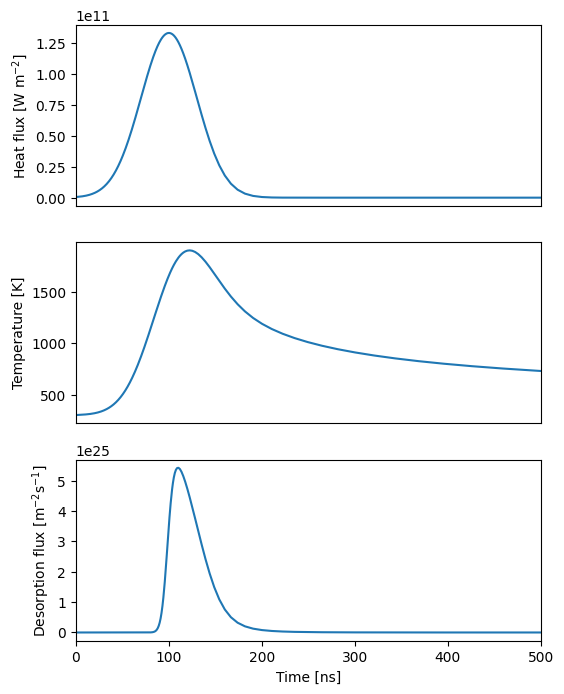

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

time = np.array(derived_quantities.t)
surf_conc = np.array(derived_quantities[0].data)
T = np.array(derived_quantities[1].data)
Heat_flux = np.array(derived_quantities[2].data)

J_des = 2e13 * surf_conc**2 / n_surf * np.exp(-1.1 / F.k_B / T)

ax[0].plot(time / 1e-9, Heat_flux)
ax[0].set_ylabel("Heat flux [W m$^{-2}$]")
ax[0].tick_params(bottom=False, labelbottom=False)

ax[1].plot(time / 1e-9, T)
ax[1].set_ylabel("Temperature [K]")
ax[1].tick_params(bottom=False, labelbottom=False)

ax[2].plot(time / 1e-9, J_des)
ax[2].set_ylabel(r"Desorption flux [m$^{-2}$s$^{-1}$]")
ax[2].set_xlabel("Time [ns]")
ax[2].set_xlim(0, 500)

plt.show()

Additionally, we can plot temporal evolution of the adsorbed hydrogen concentration and its derivative. We will also show time-dependencies of hydrogen fluxes from the surface to the subsurface ($J_{\mathrm{sb}}$) and vice-versa ($J_{\mathrm{bs}}$). Near the heat flux peak, hydrogen surface concentration evolves quickly, but it approaches quasi-equilibrium value after the end of the desorption phase (i.e. temporal derivative approaches zero).

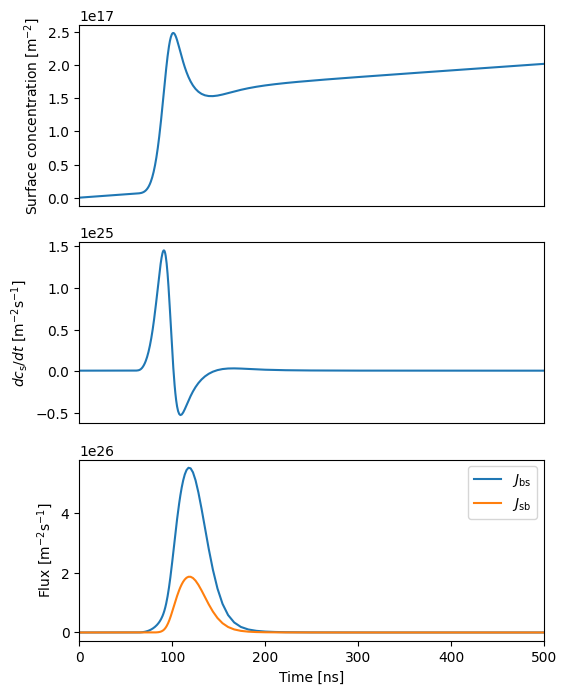

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

solute_0 = np.array(derived_quantities[3].data)

dsurf_conc = np.diff(surf_conc) / np.diff(time)
J_bs = 1e13 * np.exp(-0.2 / F.k_B / T) * solute_0 * lambda_W * (1 - surf_conc / n_surf)
J_sb = 1e13 * np.exp(-1.5 / F.k_B / T) * surf_conc * (1 - solute_0 / n_IS)

ax[0].plot(time / 1e-9, surf_conc)
ax[0].set_ylabel("Surface concentration [m$^{-2}$]")
ax[0].tick_params(bottom=False, labelbottom=False)

ax[1].plot(time[1:] / 1e-9, dsurf_conc)
ax[1].set_ylabel(r"$dc_{\mathrm{s}}/dt$ [m$^{-2}$s$^{-1}$]")
ax[1].tick_params(bottom=False, labelbottom=False)

ax[2].plot(time / 1e-9, J_bs, label=r"$J_{\mathrm{bs}}$")
ax[2].plot(time / 1e-9, J_sb, label=r"$J_{\mathrm{sb}}$")
ax[2].set_ylabel("Flux [m$^{-2}$s$^{-1}$]")
ax[2].set_xlabel("Time [ns]")
ax[2].legend()
ax[2].set_xlim(0, 500)

plt.show()